<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1:
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [2]:
!pip install -qq xgboost optuna

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv("sales.csv")

df.head()

id      date    city       lat      long     pop    shop        brand  \
0   0  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
1   1  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
2   2  31/01/12  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
3   3  31/01/12  Athens  37.97945  23.71622  672130  shop_1   adult-cola   
4   4  31/01/12  Athens  37.97945  23.71622  672130  shop_1   adult-cola   

  container capacity  price  quantity  
0     glass    500ml   0.96     13280  
1   plastic    1.5lt   2.86      6727  
2       can    330ml   0.87      9848  
3     glass    500ml   1.00     20050  
4       can    330ml   0.39     25696

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7456 entries, 0 to 7455
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7456 non-null   int64  
 1   date       7456 non-null   object 
 2   city       7456 non-null   object 
 3   lat        7456 non-null   float64
 4   long       7456 non-null   float64
 5   pop        7456 non-null   int64  
 6   shop       7456 non-null   object 
 7   brand      7456 non-null   object 
 8   container  7456 non-null   object 
 9   capacity   7456 non-null   object 
 10  price      7456 non-null   float64
 11  quantity   7456 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 699.1+ KB


In [5]:
def convert_capacity_to_ml(capacity):
    if 'ml' in capacity:
        return float(capacity.replace('ml', ''))
    elif 'lt' in capacity:
        return float(capacity.replace('lt', '')) * 1000
    else:
        raise ValueError(f"Unknown capacity format: {capacity}")
df['capacity'] = df['capacity'].apply(convert_capacity_to_ml)
df['capacity'].head()

0     500.0
1    1500.0
2     330.0
3     500.0
4     330.0
Name: capacity, dtype: float64

In [6]:
categ_cols = ["city", "shop", "brand", "container"]
for col in categ_cols:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7456 entries, 0 to 7455
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         7456 non-null   int64   
 1   date       7456 non-null   object  
 2   city       7456 non-null   category
 3   lat        7456 non-null   float64 
 4   long       7456 non-null   float64 
 5   pop        7456 non-null   int64   
 6   shop       7456 non-null   category
 7   brand      7456 non-null   category
 8   container  7456 non-null   category
 9   capacity   7456 non-null   float64 
 10  price      7456 non-null   float64 
 11  quantity   7456 non-null   int64   
dtypes: category(4), float64(4), int64(3), object(1)
memory usage: 496.0+ KB


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [7]:
from sklearn import set_config
set_config(transform_output="pandas")

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["quantity"])
y = df["quantity"]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=42, shuffle=False)

print(f"X train shape: {X_train.shape}, y train shape: {y_train.shape}")
print(f"X validation shape: {X_val.shape}, y validation shape: {y_val.shape}")
print(f"X test shape: {X_test.shape}, y test shape: {y_test.shape}")

X train shape: (5219, 11), y train shape: (5219,)
X validation shape: (1498, 11), y validation shape: (1498,)
X test shape: (739, 11), y test shape: (739,)


In [9]:
from sklearn.preprocessing import FunctionTransformer

def get_info_date(df):
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')
    df['day'] = df['date'].dt.day.astype('category')
    df['month'] = df['date'].dt.month.astype('category')
    df['year'] = df['date'].dt.year.astype('category')
    return df.drop(columns=['date'])

date_transformer = FunctionTransformer(get_info_date, validate=False)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

categ_cols = ["city", "shop", "brand", "container", "year", "month", "day"]
numeric_cols = ["lat", "long", "pop", "capacity", "price"]

categ_numeric_transformer = ColumnTransformer(
    transformers=[
        ("categ", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categ_cols),
        ("numeric", StandardScaler(), numeric_cols)
    ],
)

preprocessor = Pipeline(
    steps=[
        ("date", date_transformer),
        ("categ_numeric", categ_numeric_transformer)
    ]
).set_output(transform="pandas")

dummy_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dummy", DummyRegressor())
    ]
)

dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date',
                                  FunctionTransformer(func=<function get_info_date at 0x00000179B4FA49A0>)),
                                 ('categ_numeric',
                                  ColumnTransformer(transformers=[('categ',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['city',
                                                                    'shop',
                                                                    'brand',
                                                                    'container',
                                                                    'year',
                                                                    'month',
                                                                    'day']),
                                                                  ('numeric',
                                                                   StandardScaler(),
                                                                   ['lat',
                                                                    'long',
                                                                    'pop',
                                                                    'capacity',
                                                                    'price'])]))])),
                ('dummy', DummyRegressor())])

In [11]:
val_pred = dummy_pipeline.predict(X_val)
mae_dummy = mean_absolute_error(y_val, val_pred)
print(f"Validation MAE Dummy model: {mae_dummy}")

Validation MAE Dummy model: 12484.902691741254


**RESPUESTA 1.5**: El MAE se puede interpretar como el error (tanto por arriba como por debajo) promedio, que tiene el modelo al intentar predecir la demanda. En particular, podemos ver que, en este caso, el modelo se equivoca en alrededor de ~12500 unidades, tanto por arriba como por debajo, al intentar predecir la demanda.

In [12]:
from xgboost import XGBRegressor

xgbregressor_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("xgb", XGBRegressor())
    ]
)

xgbregressor_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date',
                                  FunctionTransformer(func=<function get_info_date at 0x00000179B4FA49A0>)),
                                 ('categ_numeric',
                                  ColumnTransformer(transformers=[('categ',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['city',
                                                                    'shop',
                                                                    'brand',
                                                                    'container',
                                                                    'year',
                                                                    'month',
                                                                    'day']),
                                                                  ('numeric',
                                                                   StandardScaler(),
                                                                   ['lat',
                                                                    'long',
                                                                    'pop',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [13]:
xgbregressor_pred = xgbregressor_pipeline.predict(X_val)
mae_xgbregressor = mean_absolute_error(y_val, xgbregressor_pred)
print(f"Validation MAE XGBRegressor model: {mae_xgbregressor}")

Validation MAE XGBRegressor model: 2850.5761916564206


**RESPUESTA 1.6**: El MAE disminuye enormemente al usar el XGBRegressor, lo que indica que el modelo es mucho mejor que el DummyRegressor. Esto es bastante esperable, ya que el DummyRegressor simplemente predice el promedio de la variable target, lo que en general no es una buena estrategia para predecir valores. Con el XGBRegressor, el MAE disminuye a de ~12500 (que era el MAE del DummyRegressor) a ~2850, lo que indica que el modelo es mucho mejor que el DummyRegressor.

In [14]:
import joblib

joblib.dump(dummy_pipeline, "LUCAS_dummy_pipeline.pkl")
joblib.dump(xgbregressor_pipeline, "LUCAS_xgbregressor_pipeline.pkl")

['LUCAS_xgbregressor_pipeline.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [15]:
cols_post_preprocessing = xgbregressor_pipeline[0][1].get_feature_names_out()
cols_post_preprocessing

array(['categ__city_Athens', 'categ__city_Irakleion',
       'categ__city_Larisa', 'categ__city_Patra',
       'categ__city_Thessaloniki', 'categ__shop_shop_1',
       'categ__shop_shop_2', 'categ__shop_shop_3', 'categ__shop_shop_4',
       'categ__shop_shop_5', 'categ__shop_shop_6',
       'categ__brand_adult-cola', 'categ__brand_gazoza',
       'categ__brand_kinder-cola', 'categ__brand_lemon-boost',
       'categ__brand_orange-power', 'categ__container_can',
       'categ__container_glass', 'categ__container_plastic',
       'categ__year_2012', 'categ__year_2013', 'categ__year_2014',
       'categ__year_2015', 'categ__year_2016', 'categ__month_1',
       'categ__month_2', 'categ__month_3', 'categ__month_4',
       'categ__month_5', 'categ__month_6', 'categ__month_7',
       'categ__month_8', 'categ__month_9', 'categ__month_10',
       'categ__month_11', 'categ__month_12', 'categ__day_28',
       'categ__day_29', 'categ__day_30', 'categ__day_31', 'numeric__lat',
       'numeric__long'

In [16]:
cols_constraints = {
    col: -1 if col == "numeric__price" else 0 for col in cols_post_preprocessing
}
cols_constraints

{'categ__city_Athens': 0,
 'categ__city_Irakleion': 0,
 'categ__city_Larisa': 0,
 'categ__city_Patra': 0,
 'categ__city_Thessaloniki': 0,
 'categ__shop_shop_1': 0,
 'categ__shop_shop_2': 0,
 'categ__shop_shop_3': 0,
 'categ__shop_shop_4': 0,
 'categ__shop_shop_5': 0,
 'categ__shop_shop_6': 0,
 'categ__brand_adult-cola': 0,
 'categ__brand_gazoza': 0,
 'categ__brand_kinder-cola': 0,
 'categ__brand_lemon-boost': 0,
 'categ__brand_orange-power': 0,
 'categ__container_can': 0,
 'categ__container_glass': 0,
 'categ__container_plastic': 0,
 'categ__year_2012': 0,
 'categ__year_2013': 0,
 'categ__year_2014': 0,
 'categ__year_2015': 0,
 'categ__year_2016': 0,
 'categ__month_1': 0,
 'categ__month_2': 0,
 'categ__month_3': 0,
 'categ__month_4': 0,
 'categ__month_5': 0,
 'categ__month_6': 0,
 'categ__month_7': 0,
 'categ__month_8': 0,
 'categ__month_9': 0,
 'categ__month_10': 0,
 'categ__month_11': 0,
 'categ__month_12': 0,
 'categ__day_28': 0,
 'categ__day_29': 0,
 'categ__day_30': 0,
 'categ__da

In [17]:
# Inserte su código acá
params = {}
params["monotone_constraints"] = cols_constraints

# Le damos params a XGBRegressor como parámetro del fit
xgbregressor_pipeline[1].set_params(**params)
xgbregressor_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date',
                                  FunctionTransformer(func=<function get_info_date at 0x00000179B4FA49A0>)),
                                 ('categ_numeric',
                                  ColumnTransformer(transformers=[('categ',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['city',
                                                                    'shop',
                                                                    'brand',
                                                                    'container',
                                                                    'year',
                                                                    'month',
                                                                    'day']),
                                                                  ('numeric',
                                                                   StandardScaler(),
                                                                   ['lat',
                                                                    'long',
                                                                    'pop',...
                                                    'categ__month_1': 0,
                                                    'categ__month_10': 0,
                                                    'categ__month_11': 0,
                                                    'categ__month_12': 0,
                                                    'categ__month_2': 0,
                                                    'categ__month_3': 0,
                                                    'categ__month_4': 0,
                                                    'categ__month_5': 0,
                                                    'categ__month_6': 0,
                                                    'categ__month_7': 0,
                                                    'categ__month_8': 0,
                                                    'categ__month_9': 0,
                                                    'categ__shop_shop_1': 0, ...},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [18]:
trained_xgb: XGBRegressor = xgbregressor_pipeline[1]
trained_xgb.monotone_constraints

{'categ__city_Athens': 0,
 'categ__city_Irakleion': 0,
 'categ__city_Larisa': 0,
 'categ__city_Patra': 0,
 'categ__city_Thessaloniki': 0,
 'categ__shop_shop_1': 0,
 'categ__shop_shop_2': 0,
 'categ__shop_shop_3': 0,
 'categ__shop_shop_4': 0,
 'categ__shop_shop_5': 0,
 'categ__shop_shop_6': 0,
 'categ__brand_adult-cola': 0,
 'categ__brand_gazoza': 0,
 'categ__brand_kinder-cola': 0,
 'categ__brand_lemon-boost': 0,
 'categ__brand_orange-power': 0,
 'categ__container_can': 0,
 'categ__container_glass': 0,
 'categ__container_plastic': 0,
 'categ__year_2012': 0,
 'categ__year_2013': 0,
 'categ__year_2014': 0,
 'categ__year_2015': 0,
 'categ__year_2016': 0,
 'categ__month_1': 0,
 'categ__month_2': 0,
 'categ__month_3': 0,
 'categ__month_4': 0,
 'categ__month_5': 0,
 'categ__month_6': 0,
 'categ__month_7': 0,
 'categ__month_8': 0,
 'categ__month_9': 0,
 'categ__month_10': 0,
 'categ__month_11': 0,
 'categ__month_12': 0,
 'categ__day_28': 0,
 'categ__day_29': 0,
 'categ__day_30': 0,
 'categ__da

In [19]:
monotone_val_pred = xgbregressor_pipeline.predict(X_val)
mae_monotone_xgbregressor = mean_absolute_error(y_val, monotone_val_pred)
print(f"Validation MAE XGBRegressor model with monotone constraints: {mae_monotone_xgbregressor}")

Validation MAE XGBRegressor model with monotone constraints: 2895.8919789272254


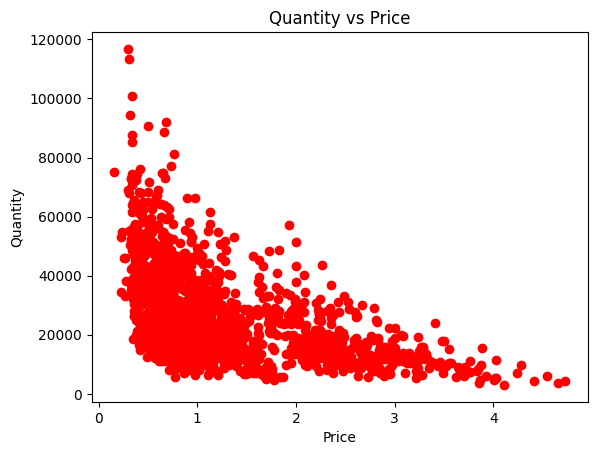

In [20]:
import matplotlib.pyplot as plt

# ploteamos quantity en función de price
plt.scatter(X_val["price"], y_val, color = 'red')
plt.title('Quantity vs Price')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.show()

**RESPUESTA 2.3**: Notemos que al agregar esta relación al modelo, en realidad los resultados cambiaron para mal. El MAE aumento a 2895, alrededor de 40 puntos por encima de los 2850 obtenidos antes. Revisando el gráfico de Precio vs Demanda, podemos ver que si existe una relación que parece inversamente proporcional en varios de los casos, sin embargo, hay una gran masa de datos que está bastante pegada a valores bajos tanto en Price como en Quantity, lo que hace que la relación no sea tan clara, y por lo tanto, puede quizás explica el aumento en el MAE.

In [21]:
joblib.dump(xgbregressor_pipeline, "xgbregressor_pipeline_LUCAS_MONOTONE.pkl")

['xgbregressor_pipeline_LUCAS_MONOTONE.pkl']

## 3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [22]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Inserte su código acá

def objective(trial):
    xgboost_params = {
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
    }
    
    onehot_params = {
        "min_frequency": trial.suggest_float("min_frequency", 0.0, 1.0)
    }
    
    numeric_categoric_pipeline = ColumnTransformer(
        transformers=[
            ("categ", OneHotEncoder(sparse_output=False, handle_unknown='ignore', **onehot_params), categ_cols),
            ("numeric", StandardScaler(), numeric_cols)
        ],
    )
    
    preprocessor = Pipeline(
        steps=[
            ("date", date_transformer),
            ("categ_numeric", numeric_categoric_pipeline)
        ]
    ).set_output(transform="pandas")
    
    preprocessor.fit(X_train)
    
    xgbregressor_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("xgb", XGBRegressor(**xgboost_params))
        ]
    )
    
    xgbregressor_pipeline.fit(
        X_train,
        y_train,
        xgb__eval_set=[(preprocessor.transform(X_train), y_train), (preprocessor.transform(X_val), y_val)],
    )
    
    val_pred = xgbregressor_pipeline.predict(X_val)
    return mean_absolute_error(val_pred, y_val)

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, timeout=300)

study.best_params

[0]	validation_0-mae:13496.81745	validation_1-mae:12176.66987
[1]	validation_0-mae:13161.36332	validation_1-mae:11887.46437
[2]	validation_0-mae:12841.13708	validation_1-mae:11619.81680
[3]	validation_0-mae:12534.27846	validation_1-mae:11363.10878
[4]	validation_0-mae:12241.84777	validation_1-mae:11116.41999
[5]	validation_0-mae:11965.19430	validation_1-mae:10893.29355
[6]	validation_0-mae:11701.22316	validation_1-mae:10673.96640
[7]	validation_0-mae:11452.20800	validation_1-mae:10470.41339
[8]	validation_0-mae:11216.00168	validation_1-mae:10276.77384
[9]	validation_0-mae:10993.38611	validation_1-mae:10097.97038
[10]	validation_0-mae:10780.88280	validation_1-mae:9923.94434
[11]	validation_0-mae:10580.84488	validation_1-mae:9760.56094
[12]	validation_0-mae:10391.59895	validation_1-mae:9609.24026
[13]	validation_0-mae:10211.52848	validation_1-mae:9476.89394
[14]	validation_0-mae:10037.67902	validation_1-mae:9335.05328
[15]	validation_0-mae:9873.02081	validation_1-mae:9212.90806
[16]	vali

{'learning_rate': 0.07526138822352611,
 'n_estimators': 856,
 'max_depth': 9,
 'max_leaves': 90,
 'min_child_weight': 1,
 'reg_alpha': 0.9552070874108354,
 'reg_lambda': 0.37321392714383345,
 'min_frequency': 0.028683123724892644}

In [23]:
study.set_user_attr("best_params", study.best_params)

In [24]:
mae_optuna = study.best_value
print(f"MAE: {mae_optuna:.2f}")
print(f"Best params: {study.best_params}")
print(f"Number of finished trials: {len(study.trials)}")

MAE: 2514.52
Best params: {'learning_rate': 0.07526138822352611, 'n_estimators': 856, 'max_depth': 9, 'max_leaves': 90, 'min_child_weight': 1, 'reg_alpha': 0.9552070874108354, 'reg_lambda': 0.37321392714383345, 'min_frequency': 0.028683123724892644}
Number of finished trials: 84


In [25]:
optuna.visualization.plot_optimization_history(study)

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [26]:
!pip install optuna-integration[xgboost]


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from optuna.integration import XGBoostPruningCallback

def objective(trial):
    xgboost_params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
    }
    
    onehot_params = {
        "min_frequency": trial.suggest_float("min_frequency", 0.0, 1.0)
    }
    
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-mae")
    
    numeric_categoric_pipeline = ColumnTransformer(
        transformers=[
            ("categ", OneHotEncoder(sparse_output=False, handle_unknown='ignore', **onehot_params), categ_cols),
            ("numeric", StandardScaler(), numeric_cols)
        ],
    )
    
    preprocessor = Pipeline(
        steps=[
            ("date", date_transformer),
            ("categ_numeric", numeric_categoric_pipeline)
        ]
    ).set_output(transform="pandas")
    
    preprocessor.fit(X_train)
    
    xgbregressor_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("xgb", XGBRegressor(callbacks=[pruning_callback], **xgboost_params))
        ]
    )
    
    xgbregressor_pipeline.fit(
        X_train,
        y_train,
        xgb__eval_set=[(preprocessor.transform(X_train), y_train), (preprocessor.transform(X_val), y_val)],
    )
    
    val_pred = xgbregressor_pipeline.predict(X_val)
    return mean_absolute_error(val_pred, y_val)

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, timeout=300)

study.best_params

[0]	validation_0-mae:13496.81745	validation_1-mae:12176.66987
[1]	validation_0-mae:13161.36332	validation_1-mae:11887.46437
[2]	validation_0-mae:12841.13708	validation_1-mae:11619.81680
[3]	validation_0-mae:12534.27846	validation_1-mae:11363.10878
[4]	validation_0-mae:12241.84777	validation_1-mae:11116.41999
[5]	validation_0-mae:11965.19430	validation_1-mae:10893.29355
[6]	validation_0-mae:11701.22316	validation_1-mae:10673.96640
[7]	validation_0-mae:11452.20800	validation_1-mae:10470.41339
[8]	validation_0-mae:11216.00168	validation_1-mae:10276.77384
[9]	validation_0-mae:10993.38611	validation_1-mae:10097.97038
[10]	validation_0-mae:10780.88280	validation_1-mae:9923.94434
[11]	validation_0-mae:10580.84488	validation_1-mae:9760.56094
[12]	validation_0-mae:10391.59895	validation_1-mae:9609.24026
[13]	validation_0-mae:10211.52848	validation_1-mae:9476.89394
[14]	validation_0-mae:10037.67902	validation_1-mae:9335.05328
[15]	validation_0-mae:9873.02081	validation_1-mae:9212.90806
[16]	vali

[204]	validation_0-mae:1427.20649	validation_1-mae:2707.98347
[205]	validation_0-mae:1421.47474	validation_1-mae:2705.99978
[206]	validation_0-mae:1417.22159	validation_1-mae:2705.30885
[207]	validation_0-mae:1414.41829	validation_1-mae:2703.95771
[208]	validation_0-mae:1411.54763	validation_1-mae:2706.36294
[209]	validation_0-mae:1409.01527	validation_1-mae:2705.43459
[210]	validation_0-mae:1406.33430	validation_1-mae:2706.97656
[211]	validation_0-mae:1402.44392	validation_1-mae:2705.55471
[212]	validation_0-mae:1400.36878	validation_1-mae:2704.99908
[213]	validation_0-mae:1398.10280	validation_1-mae:2705.07162
[214]	validation_0-mae:1394.85438	validation_1-mae:2703.17502
[215]	validation_0-mae:1392.51487	validation_1-mae:2702.32945
[216]	validation_0-mae:1389.41633	validation_1-mae:2701.59118
[217]	validation_0-mae:1387.14980	validation_1-mae:2701.75767
[218]	validation_0-mae:1381.73836	validation_1-mae:2698.56121
[219]	validation_0-mae:1379.81005	validation_1-mae:2699.65423
[220]	va

{'learning_rate': 0.09997819203478393,
 'n_estimators': 835,
 'max_depth': 6,
 'max_leaves': 61,
 'min_child_weight': 1,
 'reg_alpha': 0.48836437402613675,
 'reg_lambda': 0.09864345604848684,
 'min_frequency': 0.02288167814862141}

In [28]:
mae_optuna_pruning = study.best_value
print(f"MAE: {mae_optuna_pruning:.2f}")
print(f"Best params: {study.best_params}")
print(f"Number of finished trials: {len(study.trials)}")

MAE: 2505.55
Best params: {'learning_rate': 0.09997819203478393, 'n_estimators': 835, 'max_depth': 6, 'max_leaves': 61, 'min_child_weight': 1, 'reg_alpha': 0.48836437402613675, 'reg_lambda': 0.09864345604848684, 'min_frequency': 0.02288167814862141}
Number of finished trials: 169


In [29]:
best_params_pruning = study.best_params
onehot_min_freq = best_params_pruning["min_frequency"]
best_params_pruning.pop("min_frequency")
xgb_best_params = best_params_pruning

In [30]:
numeric_categoric_pipeline = ColumnTransformer(
        transformers=[
            ("categ", OneHotEncoder(sparse_output=False, handle_unknown='ignore', min_frequency=onehot_min_freq), categ_cols),
            ("numeric", StandardScaler(), numeric_cols)
        ],
    )
    
preprocessor = Pipeline(
    steps=[
        ("date", date_transformer),
        ("categ_numeric", numeric_categoric_pipeline)
    ]
).set_output(transform="pandas")


 
xgbregressor_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("xgb", XGBRegressor(**xgb_best_params))
    ]
)

xgbregressor_pipeline.fit(X_train, y_train)

joblib.dump(xgbregressor_pipeline, "xgbregressor_pipeline_pruned_LUCAS.pkl")

['xgbregressor_pipeline_pruned_LUCAS.pkl']

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

In [31]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances

In [32]:
plot_optimization_history(study)

In [33]:
plot_parallel_coordinate(study)

In [34]:
plot_param_importances(study)

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [36]:
mae_df = pd.DataFrame({
    "model": ["Dummy", "XGBRegressor", "XGBRegressor with monotone constraints", "XGBRegressor with Optuna", "XGBRegressor with Optuna and pruning"],
    "mae": [mae_dummy, mae_xgbregressor, mae_monotone_xgbregressor, mae_optuna, mae_optuna_pruning]
})
mae_df.sort_values("mae")

model           mae
4    XGBRegressor with Optuna and pruning   2505.547856
3                XGBRegressor with Optuna   2514.519332
1                            XGBRegressor   2850.576192
2  XGBRegressor with monotone constraints   2895.891979
0                                   Dummy  12484.902692

**RESPUESTA 6.2**: El mejor modelo, con una diferencia considerable contra los demás, y en particular contra el Baseline, es el modelo obtenido con Optuna y Prunning. Este modelo obtiene un MAE de 2505, lo que es muchisimo mejor qu el baseline (DummyRegressor) que tiene un MAE de 12500, y bastante mejor que el modelo sin usar Optuna. 

In [39]:
best_regresor = joblib.load("xgbregressor_pipeline_pruned_LUCAS.pkl")
mae_test = mean_absolute_error(y_test, best_regresor.predict(X_test))
print(f"MAE en test: {mae_test}")

MAE en test: 3375.8067417170587


**RESPUESTA 6.4**: Existe una diferencia considerable entre las métricas de validación y test, ya que el MAE en test es de 3375, mientras que en validación era de 2505. Una de las posibles razones es que el modelo, al ajustar tan finamente los hiperparámetros, puede haber caído en overfitting sobre el conjunto de validación, lo que hace que el modelo no generalice tan bien sobre el conjunto de test.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>